# 🏗️ Titanic Project

## 1. Introduction & Objectives

* Goal: Predict passenger survival (Binary Classification).

* Metric: Accuracy and Confusion Matrix.

* survival	-->        Survival	        0 = No, 1 = Yes
* pclass	-->        Ticket class	        1 = 1st, 2 = 2nd, 3 = 3rd
* sex	   -->     Sex	
* Age	  -->      Age in years	
* sibsp	   -->     # of siblings / spouses aboard the Titanic	
* parch	   -->     # of parents / children aboard the Titanic	
* ticket	-->        Ticket number	
* fare	    -->    Passenger fare	
* cabin	    -->    Cabin number	
* embarked	    -->    Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
##  2. Environment Setup

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline & Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, f1_score


# Load Data
df_before_cleaning = pd.read_csv('data/train.csv')
df = df_before_cleaning
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Data Wrangling

* Cleaning, deduplication, handling missing values.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [75]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [76]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [77]:
df.duplicated().sum()

0

No Duplicate Rows

In [78]:
df.set_index('PassengerId', inplace=True)

PassengerId is the index of each record

In [79]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Imbalanced (Not Survived Favoured)

#### Gender Analysis on Survival

In [81]:
df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [82]:
female_count = df.loc[df['Sex']=='female' , 'Survived'].count()
female_suvive = df.loc[(df['Sex']=='female') & (df['Survived']==1), 'Survived'].count()

print(f"Female Survived: {female_suvive} out of {female_count}")

Female Survived: 233 out of 314


In [83]:
male_count = df.loc[df['Sex']=='male' , 'Survived'].count()
male_suvive = df.loc[(df['Sex']=='male') & (df['Survived']==1), 'Survived'].count()

print(f"male Survived: {male_suvive} out of {male_count}")

male Survived: 109 out of 577


In [84]:
df.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

74% of females survived while only 19% of males survived

#### Handling missing values

In [85]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [86]:
df = df.drop('Cabin', axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Dropped Cabin column since too many missing values


In [87]:
average_age = df['Age'].mean().round()

df['Age'] = df['Age'].fillna(average_age)

Replaced Missing Age with Average Age

In [88]:
frequent_embarked = df['Embarked'].value_counts().idxmax()

df['Embarked'] = df['Embarked'].fillna(frequent_embarked)

df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

Replaced missing emarked values with mode

#### Binning

In [89]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.758889,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002570,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [90]:
age_bins = [min(df['Age']),12,19,29,44,59, max(df['Age'])]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']

df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=True)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_Group
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Adult
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Adult


Binned age based on **'Child', 'Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior'** labels

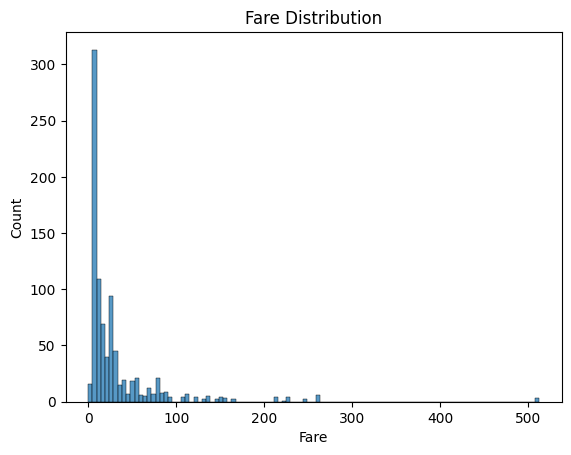

In [91]:
sns.histplot(df, x='Fare')
plt.title('Fare Distribution')
plt.show()

In [92]:
df = df.drop('Age', axis=1)
df.head()

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,Age_Group
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,Young Adult
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,Adult
3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S,Young Adult
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S,Adult
5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S,Adult


In [93]:
df_before_cleaning.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Check data type

In [94]:
df.dtypes

Survived        int64
Pclass          int64
Name           object
Sex            object
SibSp           int64
Parch           int64
Ticket         object
Fare          float64
Embarked       object
Age_Group    category
dtype: object

* Age_Group, Sex and Embarked are categories
* SibSp ,Parch and Fare are numbers
* Pclass is already encoded category
* Name and ticket are neither

In [95]:
df[['Pclass', 'Sex', 'Embarked', 'Age_Group']] = df[['Pclass', 'Sex', 'Embarked', 'Age_Group']].astype('category')
df.dtypes

Survived        int64
Pclass       category
Name           object
Sex          category
SibSp           int64
Parch           int64
Ticket         object
Fare          float64
Embarked     category
Age_Group    category
dtype: object

In [96]:
categorical_columns = df.select_dtypes(include='category')
categorical_columns.head()

,Pclass,Sex,Embarked,Age_Group
PassengerId,,,,
1,3,male,S,Young Adult
2,1,female,C,Adult
3,3,female,S,Young Adult
4,1,female,S,Adult
5,3,male,S,Adult


In [97]:
numerical_columns = df.select_dtypes(include='number').drop(columns='Survived', axis=1)
numerical_columns.head()

,SibSp,Parch,Fare
PassengerId,,,
1,1,0,7.2500
2,1,0,71.2833
3,0,0,7.9250
4,1,0,53.1000
5,0,0,8.0500


In [98]:
df['Ticket'].nunique()

681

In [99]:
df['Name'].nunique()

891

Ticket and Name are unique identifiers and not relevant features

## 4. EDA & Visualization

* Pattern discovery, trend analysis, visual inspections.

In [100]:
df.shape

(891, 10)

#### Target Variable Analysis

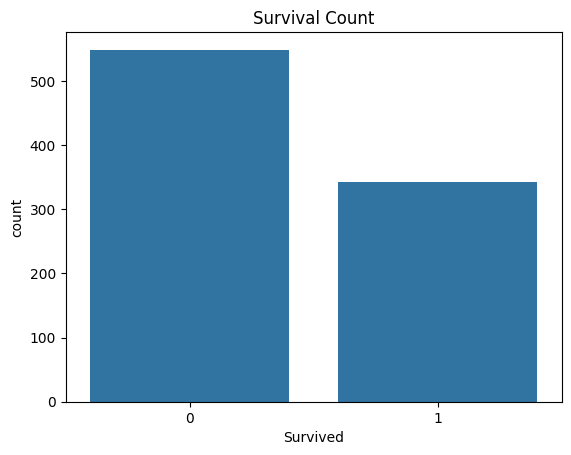

In [101]:
survived_counts = df['Survived'].value_counts()

sns.countplot(df, x='Survived')
plt.title('Survival Count')
plt.show()

#### Univariate Analysis

* ##### Numerical Variables

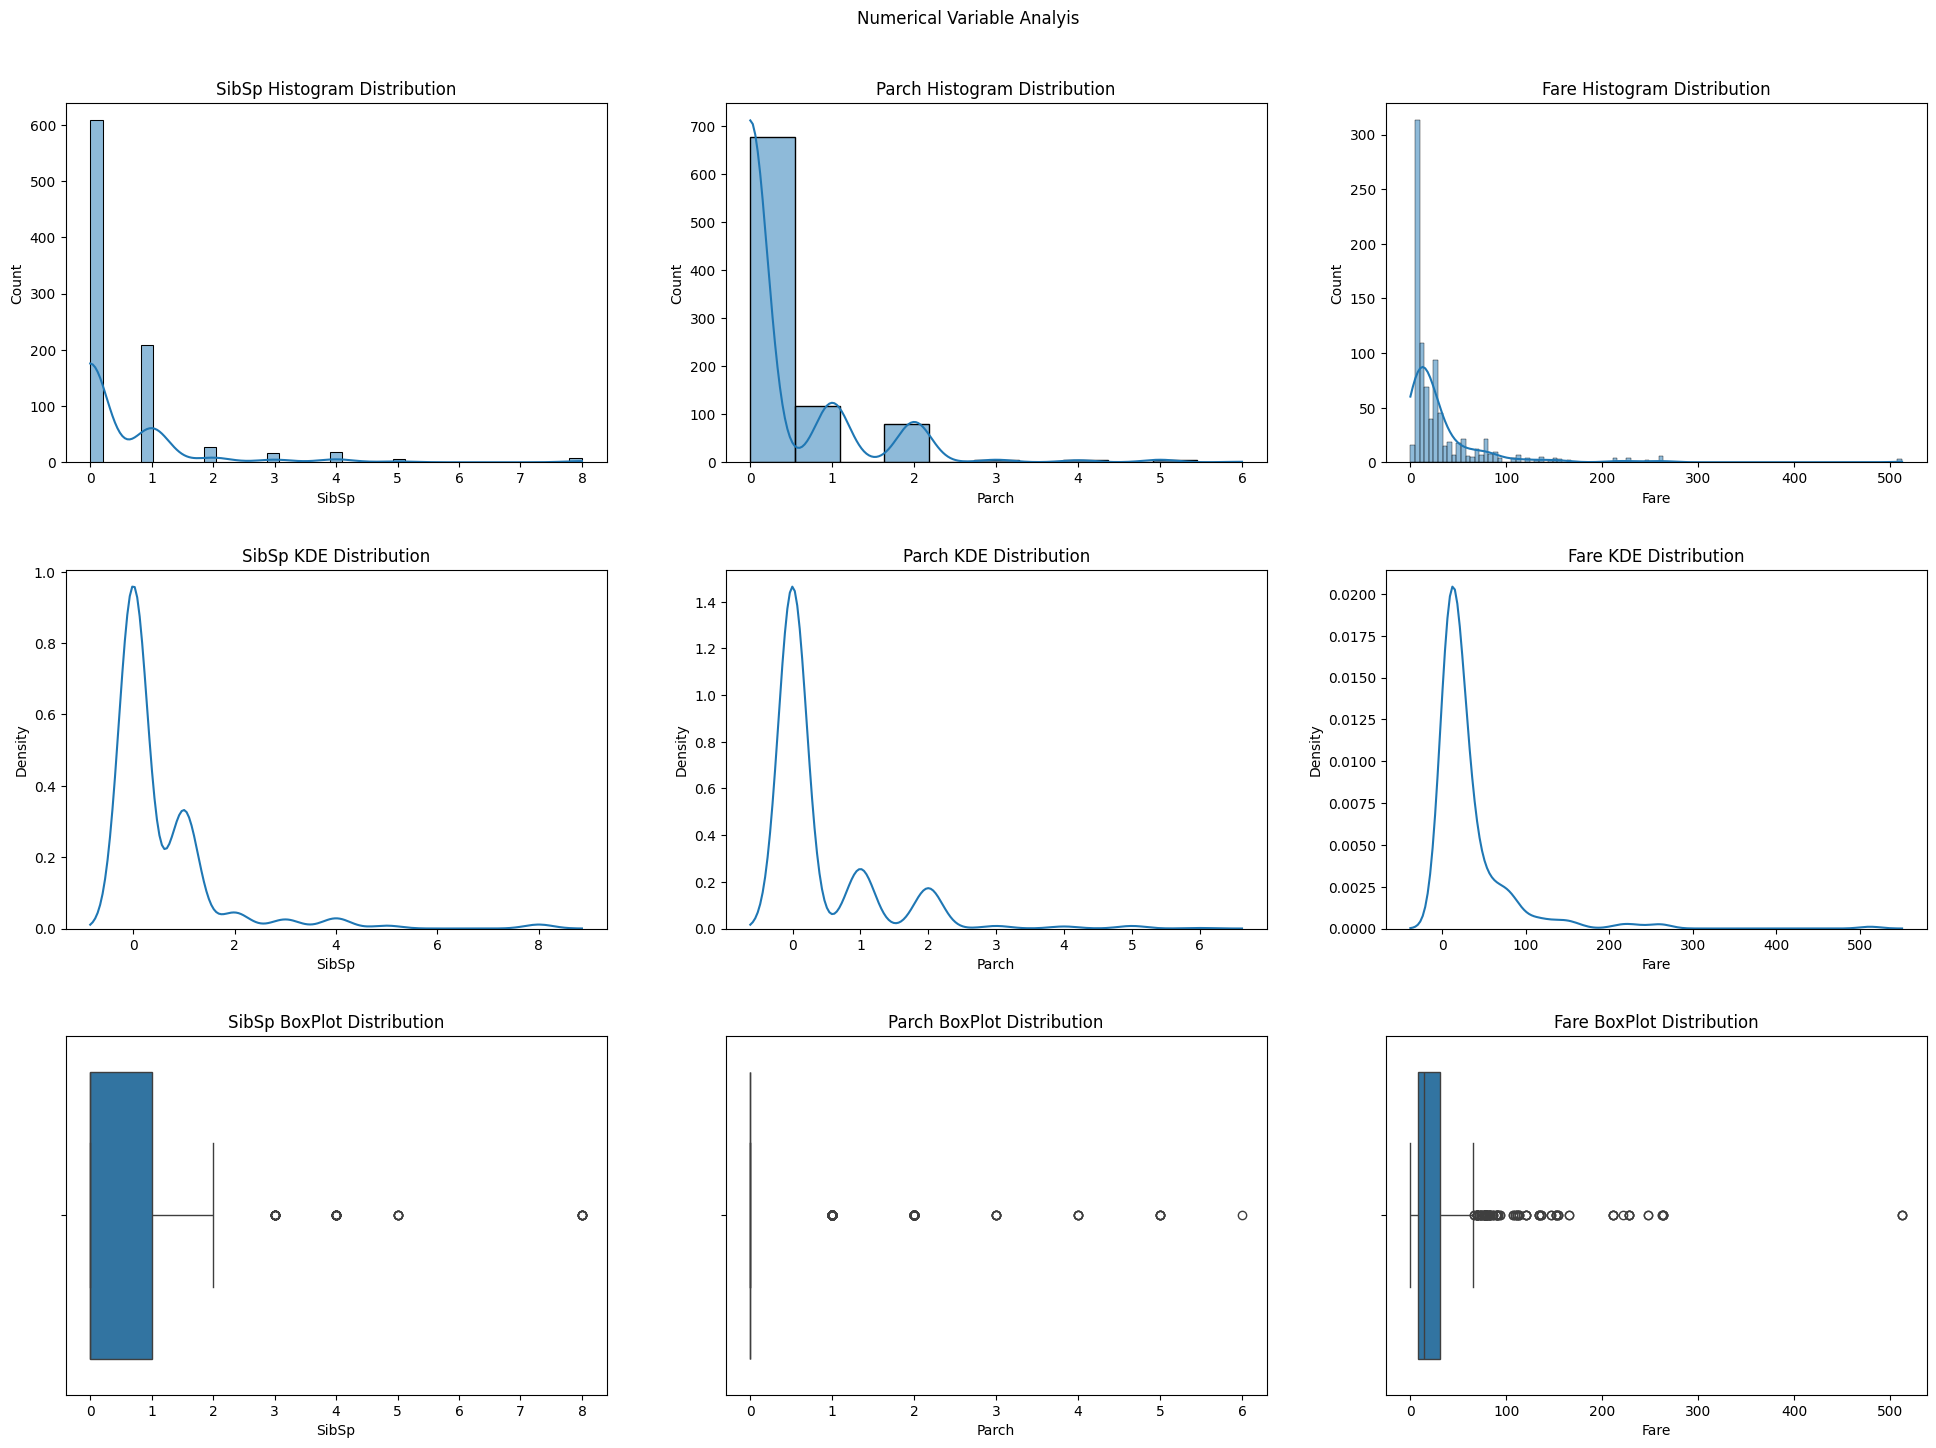

In [102]:
fig , axes = plt.subplots(3, len(numerical_columns.columns), figsize=(20, 15))

plt.suptitle("Numerical Variable Analyis")

for i, col in enumerate(numerical_columns.columns):
    sns.histplot(numerical_columns, x=col, ax= axes[0,i], kde=True)
    axes[0,i].set_title(f"{col} Histogram Distribution")

for i, col in enumerate(numerical_columns.columns):
    sns.kdeplot(numerical_columns, x=col, ax= axes[1,i])
    axes[1,i].set_title(f"{col} KDE Distribution")

for i, col in enumerate(numerical_columns.columns):
    sns.boxplot(numerical_columns, x=col, ax= axes[2,i])
    axes[2,i].set_title(f"{col} BoxPlot Distribution")

plt.tight_layout(pad=3)
plt.show()

* ##### Categorical Varibales

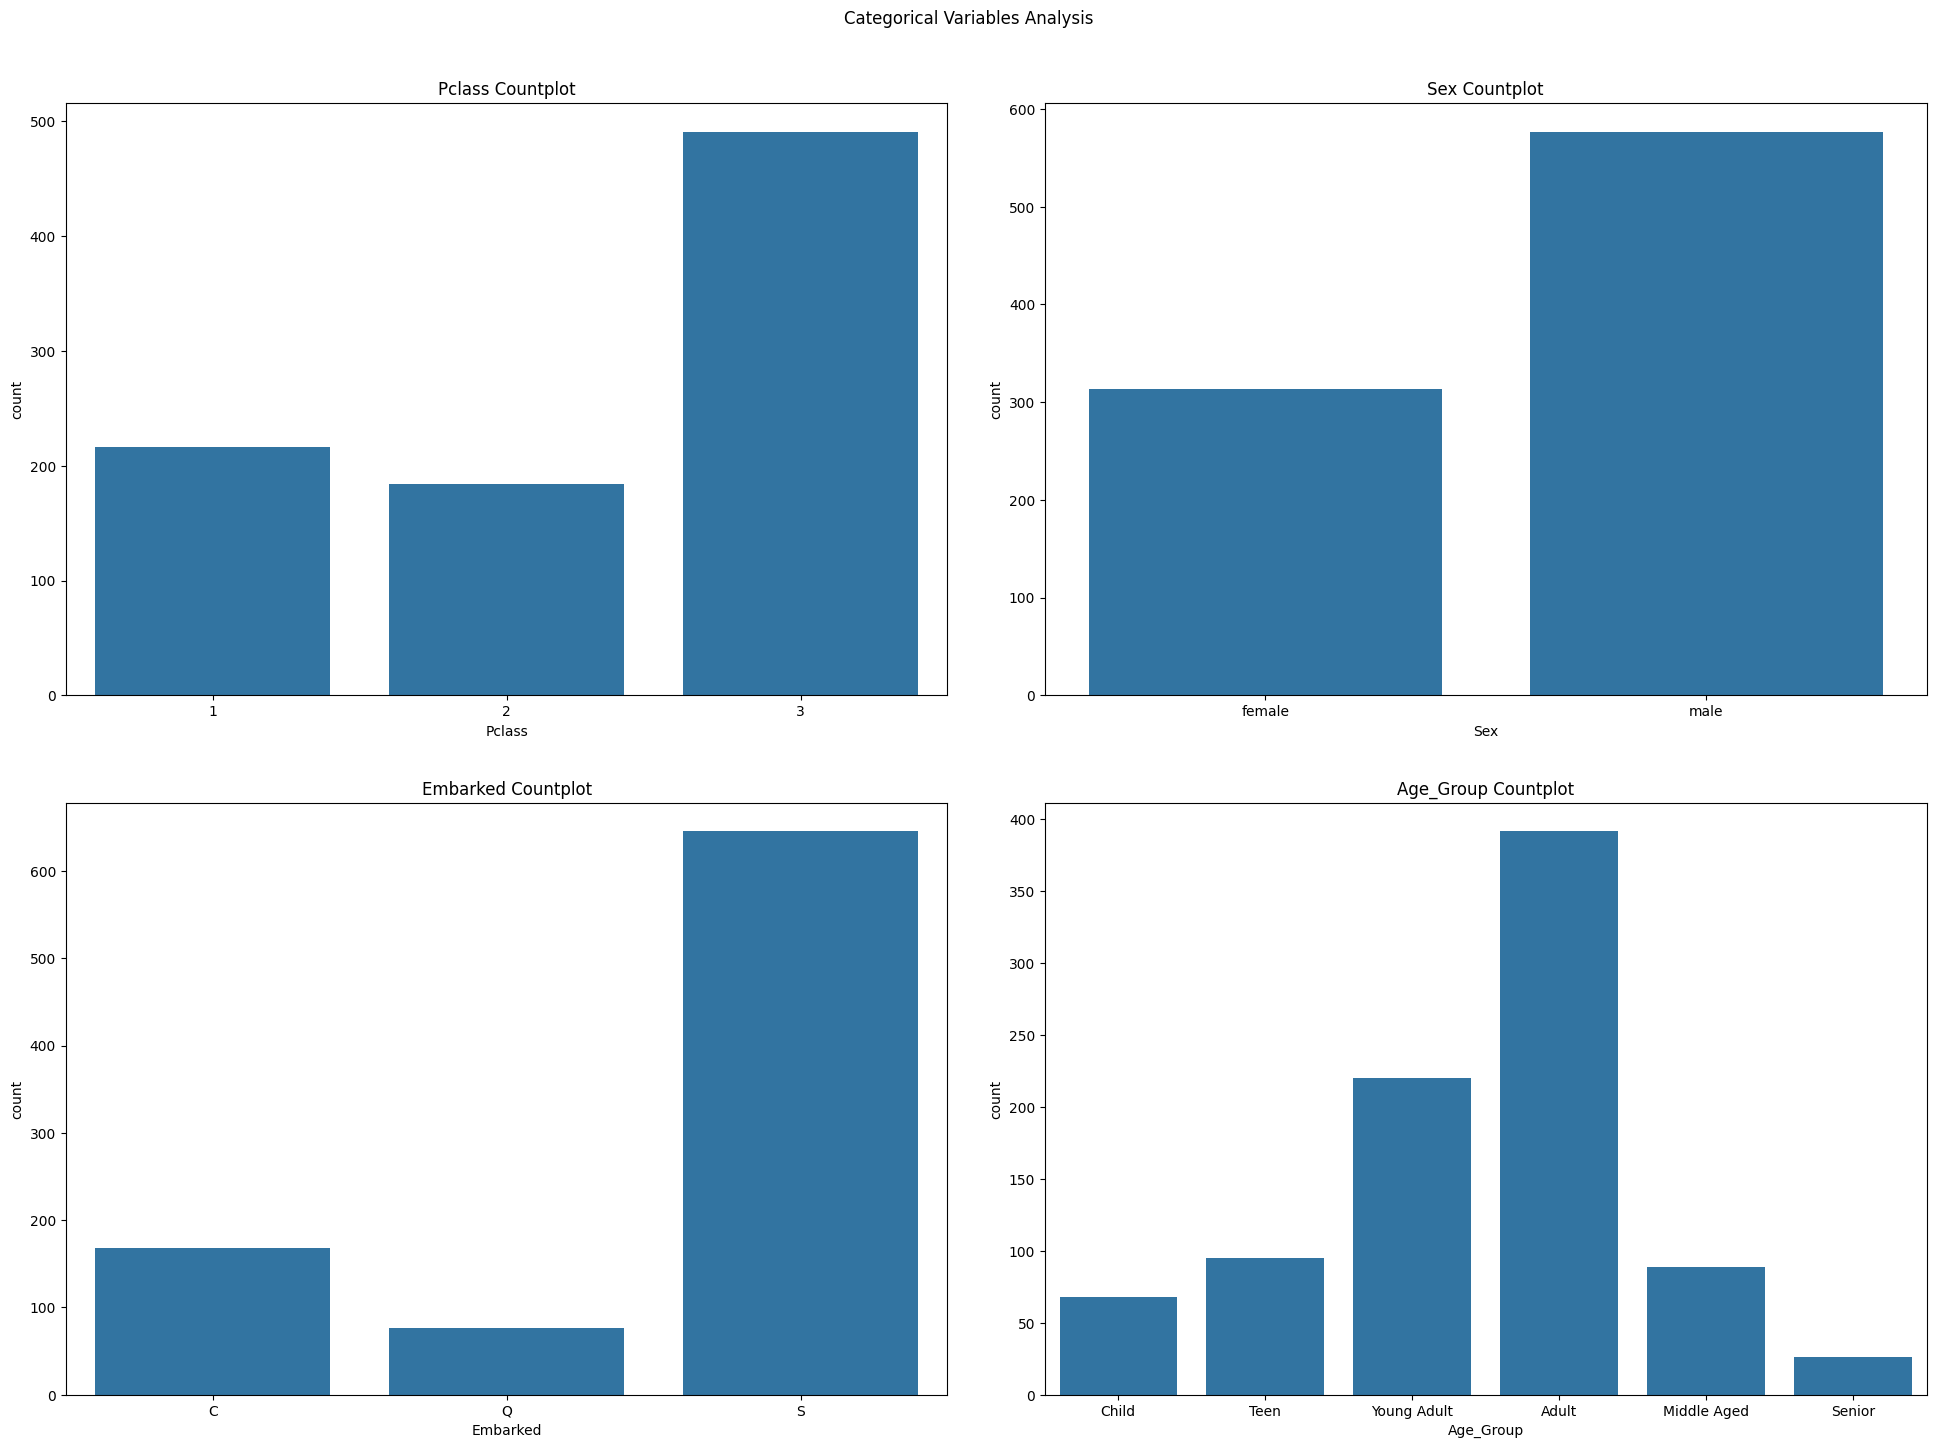

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
plt.suptitle('Categorical Variables Analysis')

for i, col in enumerate(categorical_columns.columns):
    sns.countplot(categorical_columns, x=col, ax= axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"{col} Countplot")

plt.tight_layout(pad=3)
plt.show()

#### Feature By Feature

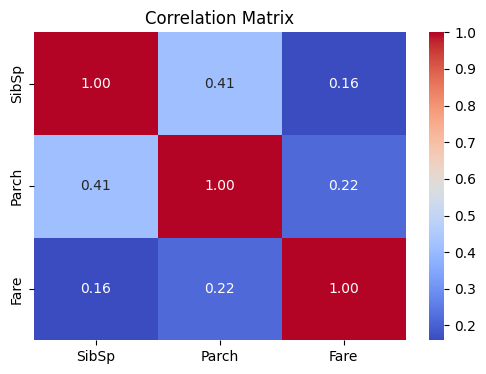

In [104]:
plt.figure(figsize=(6,4))
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

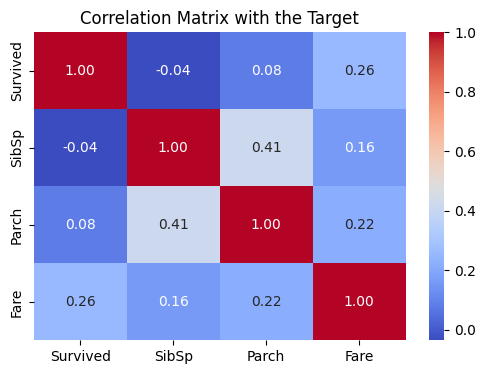

In [105]:
numerical_all = df.select_dtypes(include='number')

plt.figure(figsize=(6,4))
sns.heatmap(numerical_all.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with the Target')
plt.show()

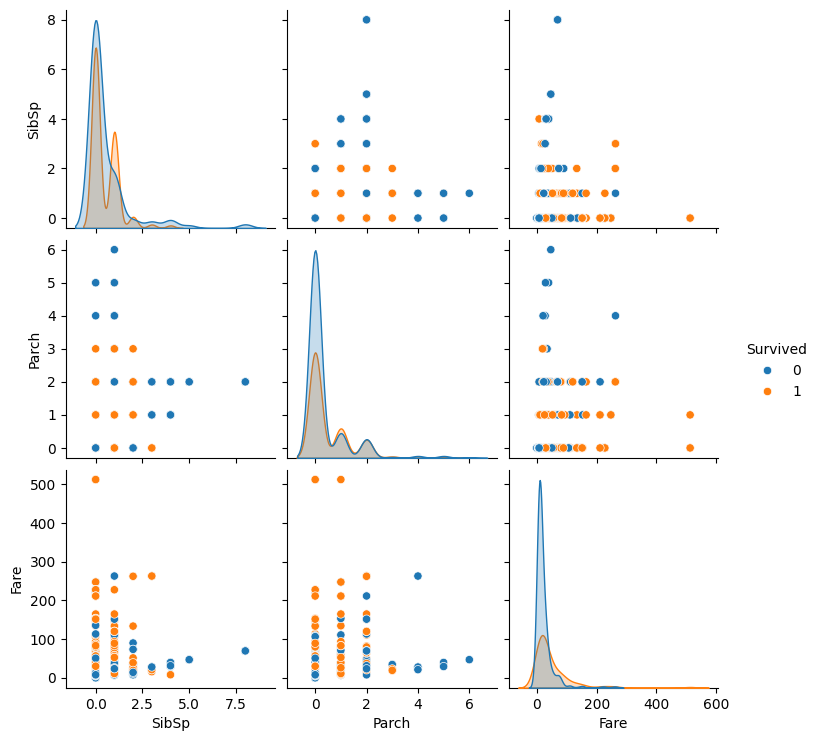

In [106]:
sns.pairplot(df, hue='Survived')
plt.show()

#### Feature by Target

* ##### Numerical Variables

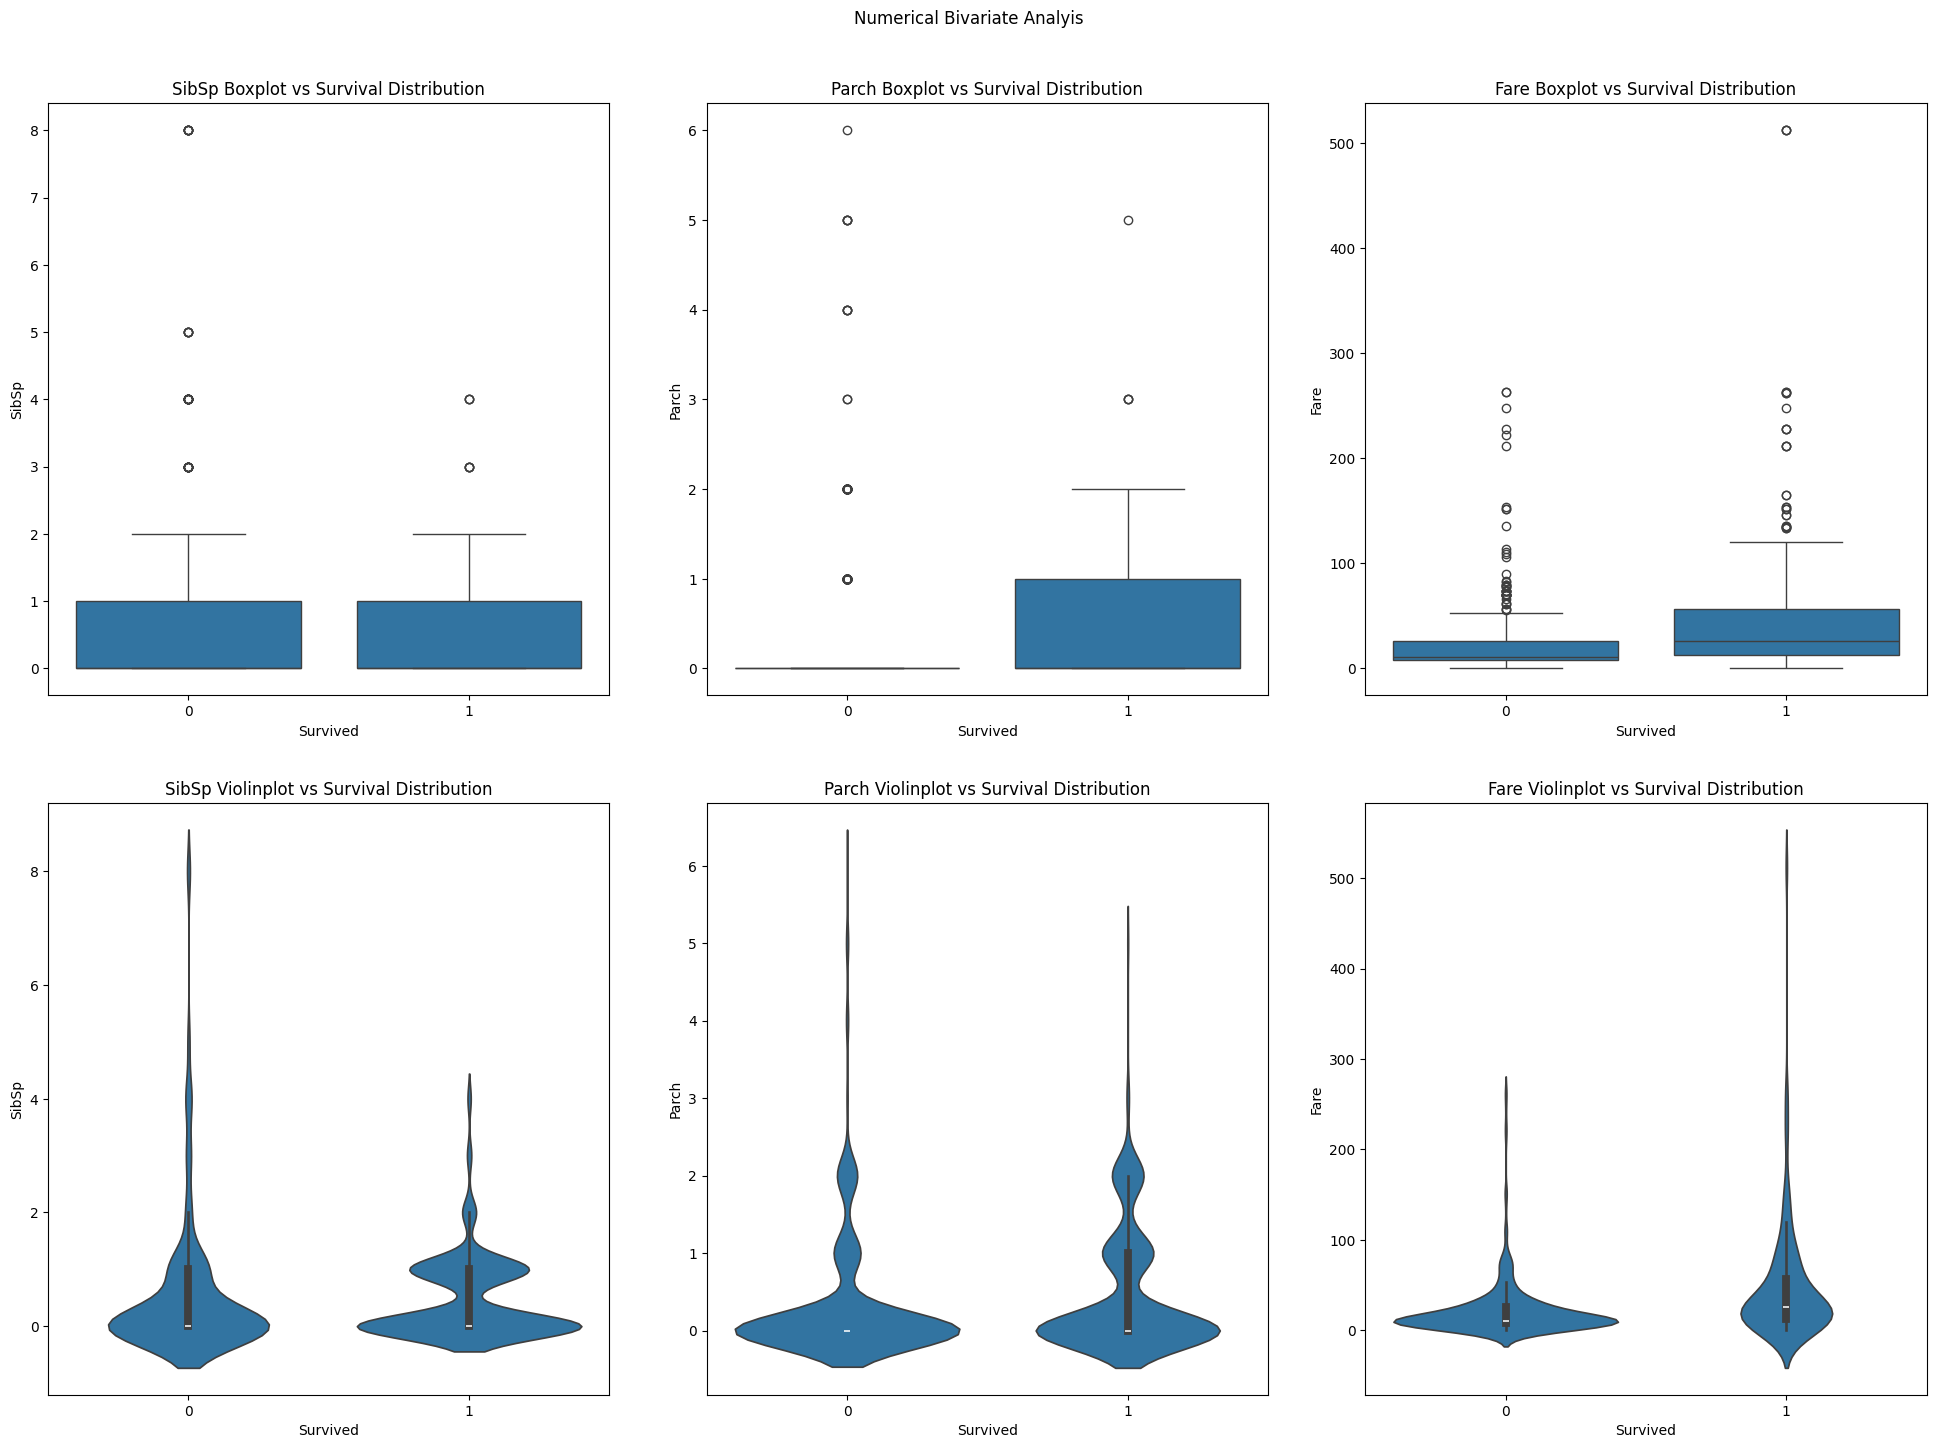

In [107]:
fig , axes = plt.subplots(2, len(numerical_columns.columns), figsize=(20, 15))

plt.suptitle("Numerical Bivariate Analyis")

for i, col in enumerate(numerical_columns.columns):
    sns.boxplot(numerical_all, x='Survived', y=col, ax= axes[0,i])
    axes[0,i].set_title(f"{col} Boxplot vs Survival Distribution")

for i, col in enumerate(numerical_columns.columns):
    sns.violinplot(numerical_all, x='Survived', y=col, ax= axes[1,i])
    axes[1,i].set_title(f"{col} Violinplot vs Survival Distribution")

plt.tight_layout(pad=3)
plt.show()

The most who survive are people who have parents or children and people who paid higher fares

* ##### Categorical Variables

In [108]:
categorical_columns['Survived'] = df['Survived']
categorical_columns.head()

,Pclass,Sex,Embarked,Age_Group,Survived
PassengerId,,,,,
1,3,male,S,Young Adult,0
2,1,female,C,Adult,1
3,3,female,S,Young Adult,1
4,1,female,S,Adult,1
5,3,male,S,Adult,0


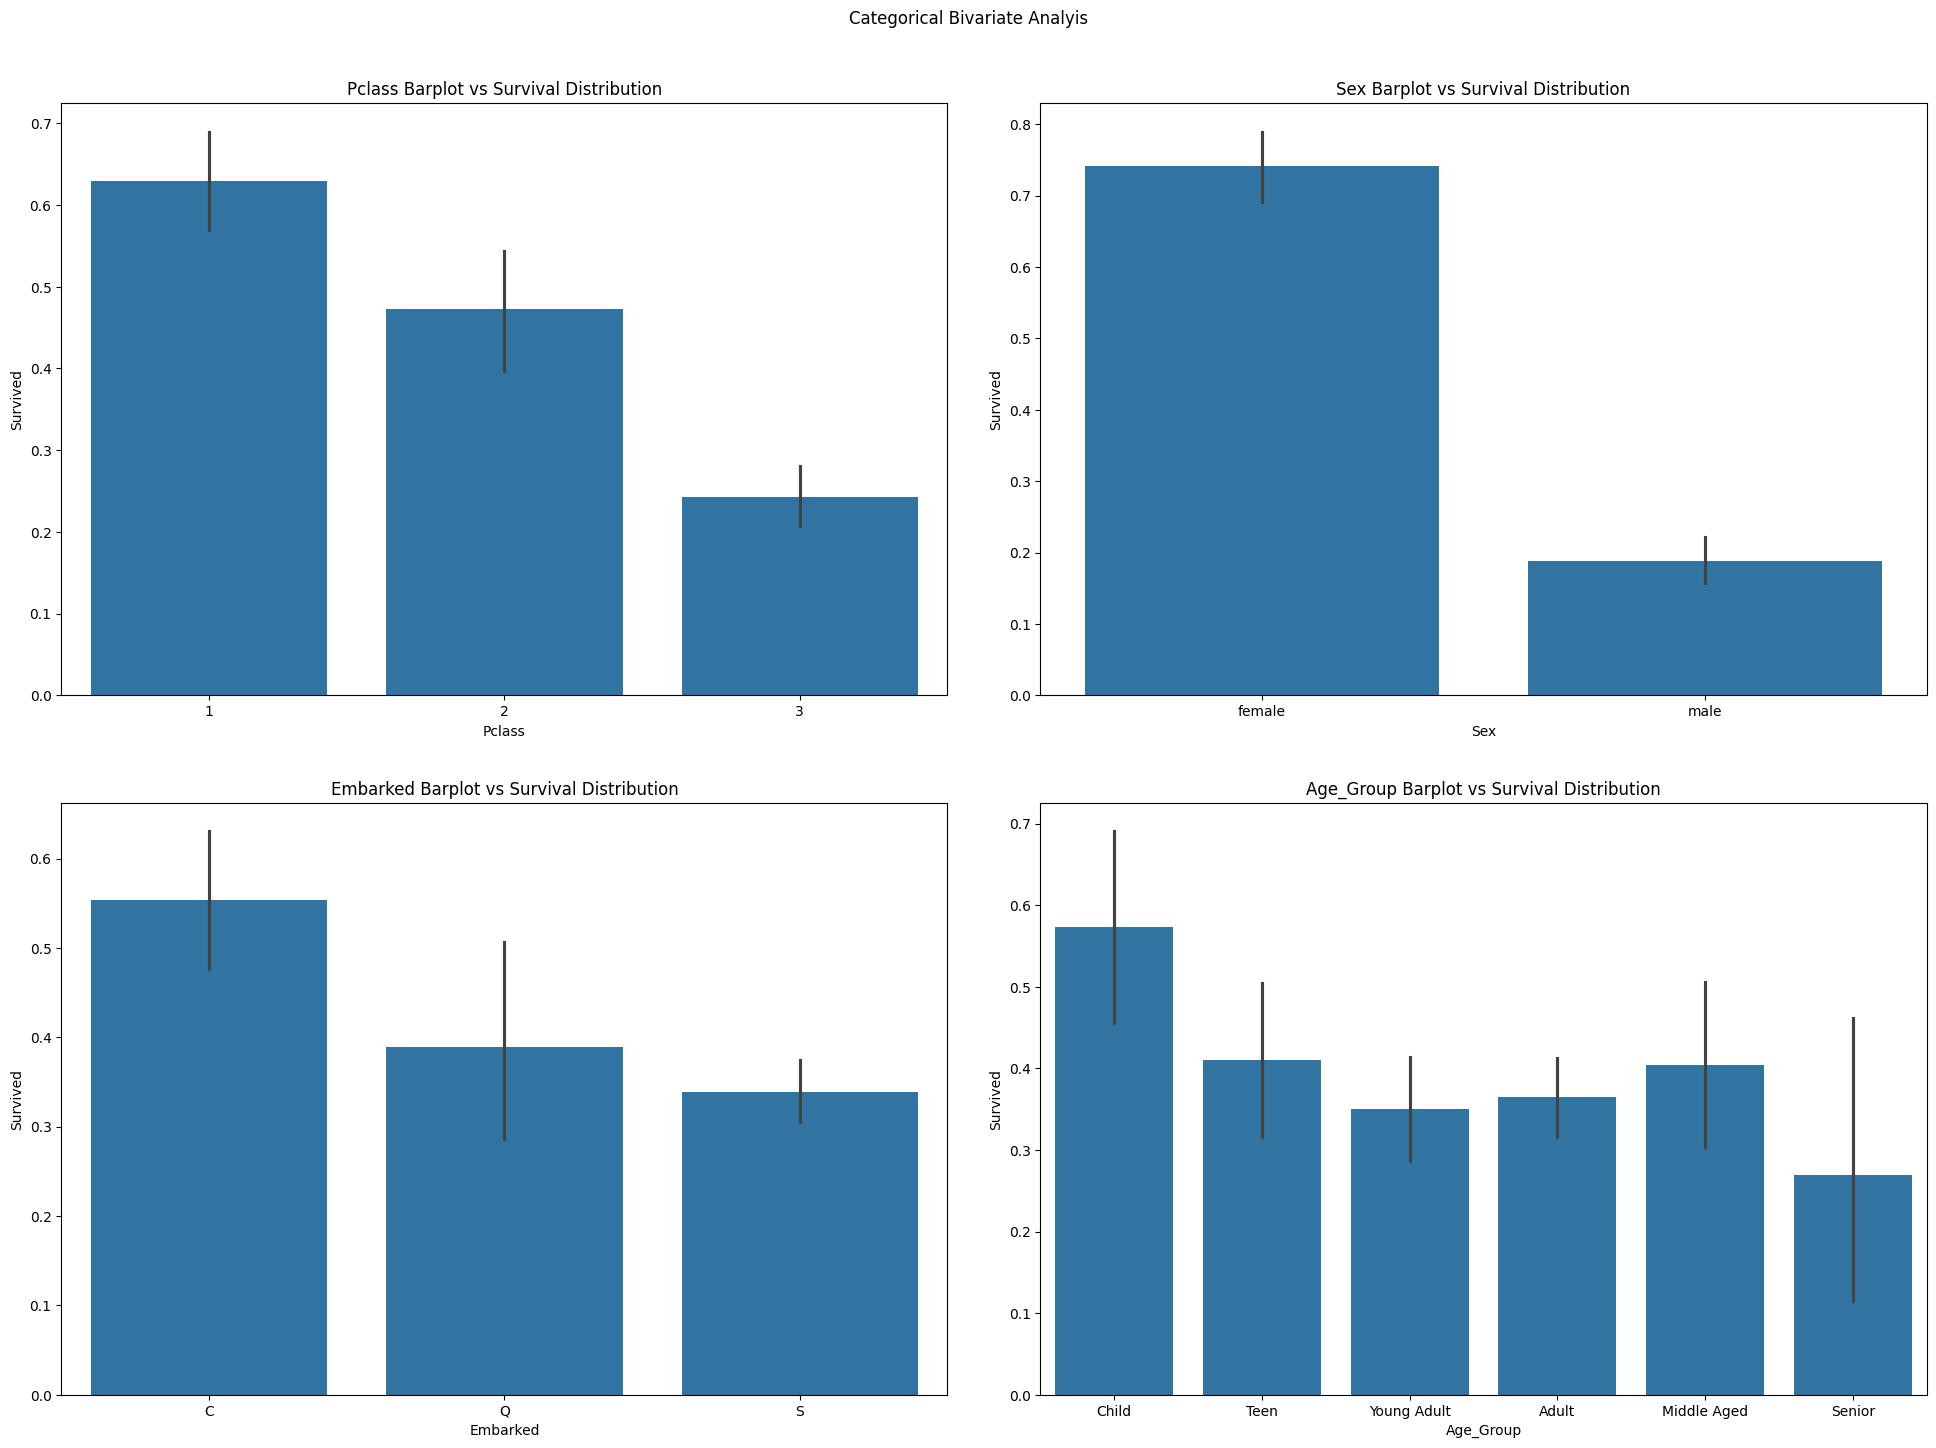

In [109]:
fig , axes = plt.subplots(2, 2, figsize=(20, 15))

plt.suptitle("Categorical Bivariate Analyis")

for i, col in enumerate(categorical_columns.columns[:4]):
    sns.barplot(categorical_columns, x=col, y='Survived', ax= axes[i//2,i%2])
    axes[i//2,i%2].set_title(f"{col} Barplot vs Survival Distribution")


plt.tight_layout(pad=3)
plt.show()

The most who survive are Females, Pclass=1, Embarked=C and Children

#### Removal of irrelevant features

In [110]:
df = df.drop(columns=['Name', 'Ticket'])

In [111]:
df.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age_Group
PassengerId,,,,,,,,
1,0,3,male,1,0,7.2500,S,Young Adult
2,1,1,female,1,0,71.2833,C,Adult
3,1,3,female,0,0,7.9250,S,Young Adult
4,1,1,female,1,0,53.1000,S,Adult
5,0,3,male,0,0,8.0500,S,Adult


In [112]:
df.dtypes

Survived        int64
Pclass       category
Sex          category
SibSp           int64
Parch           int64
Fare          float64
Embarked     category
Age_Group    category
dtype: object

## 5. ML Pipeline
* Scaling, encoding categorical variables, model pipelines.


In [113]:
X = df.drop(columns='Survived')
y = df['Survived']

In [114]:
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist()

In [115]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [116]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

In [117]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Normal Logistic Regression

In [119]:
pipe_lr = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        max_iter=1000,
        penalty='l2',
        C=1,
        class_weight='balanced',
        random_state=42
        ))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

f1_result = f1_score(y_test, y_pred)
accuracy = pipe_lr.score(X_test, y_test)

print(f"Model Accuracy = {100*accuracy:.2f}%")
print(f"Logistic Model F1 Score = {f1_result:.2f}")

Model Accuracy = 80.45%
Logistic Model F1 Score = 0.75


c:\Users\omarh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


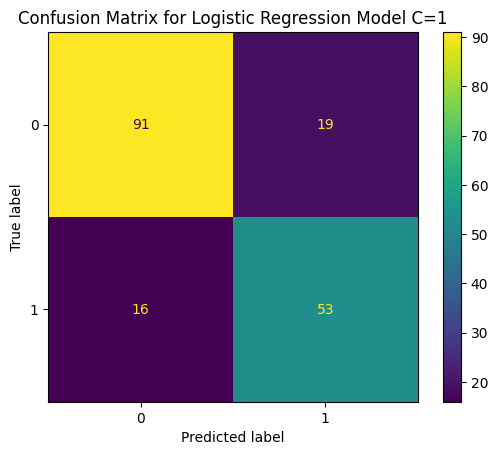

In [120]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression Model C=1')
plt.show()

In [121]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       110
           1       0.74      0.77      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.80       179
weighted avg       0.81      0.80      0.81       179



### Logistic Regression using GridSearch with different C param

In [122]:
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ['l2'],
    "model__solver": ['lbfgs'],
    "model__class_weight": ['balanced']
}


gr_lr = GridSearchCV(pipe_lr, param_grid=param_grid, cv = 5, scoring = 'f1', n_jobs=-1, verbose=2)
gr_lr.fit(X_train, y_train)

print('LR best params:', gr_lr.best_params_)
print('LR best CV score', gr_lr.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
LR best params: {'model__C': 10, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
LR best CV score 0.7376890131308829


c:\Users\omarh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Logistic Model GridSerchCV F1-Score 0.7605633802816901


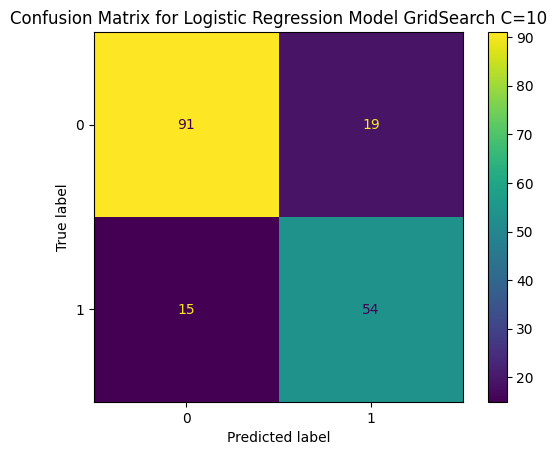

In [123]:
y_gr_pred = gr_lr.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_gr_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression Model GridSearch C=10')
f1_result_gr = f1_score(y_test, y_gr_pred)
print(f"Logistic Model GridSerchCV F1-Score {f1_result_gr}")

In [124]:
C_range = np.logspace(-4, 4, 10)

Text(0.5, 1.0, 'Validation Curve: Effect of C Parameter on Logistic Regression')

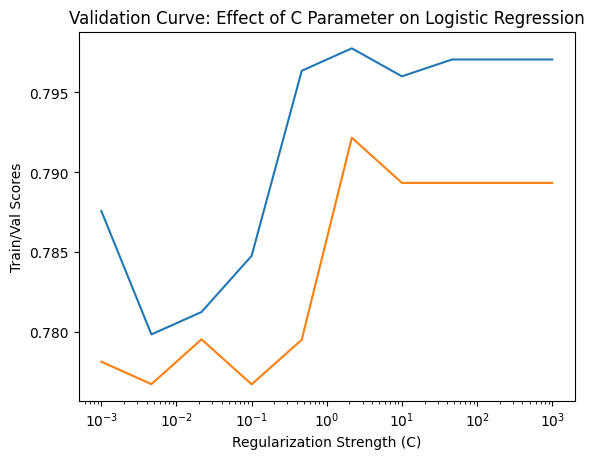

In [129]:
C_range = np.logspace(-3, 3, 10)

train_scores, val_scores = validation_curve(
    gr_lr.best_estimator_,
    X_train,
    y_train,
    param_name='model__C',
    param_range = C_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure()


plt.plot(C_range, train_mean, label= 'Training Scores')

plt.plot(C_range, val_mean, label= 'Validation Scores')

plt.xscale('log') 
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Train/Val Scores')

plt.title('Validation Curve: Effect of C Parameter on Logistic Regression')

Best C param is at around C=5

In [126]:
pipe_dt = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(random_state=42))
])

param_dt_grid = {
    "model__max_depth": [None, 3, 5, 8, 12],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__class_weight": ["balanced"]
}

gr_dt = GridSearchCV(pipe_dt, param_grid=param_dt_grid, cv = 5, scoring='f1', n_jobs=-1, verbose=1)

gr_dt.fit(X_train, y_train)

dt_best_params = gr_dt.best_params_
dt_best_score = gr_dt.best_score_

y_dt_pred = gr_dt.best_estimator_.predict(X_test)

f1_result_dt = f1_score(y_test, y_dt_pred)

print(f"Model Best Params: {dt_best_params}")
print(f"Model Best Accuracy Score: {dt_best_score}")
print(f"Model Best F1-Score: {f1_result_dt}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Model Best Params: {'model__class_weight': 'balanced', 'model__max_depth': 8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
Model Best Accuracy Score: 0.7455004076908914
Model Best F1-Score: 0.7034482758620689


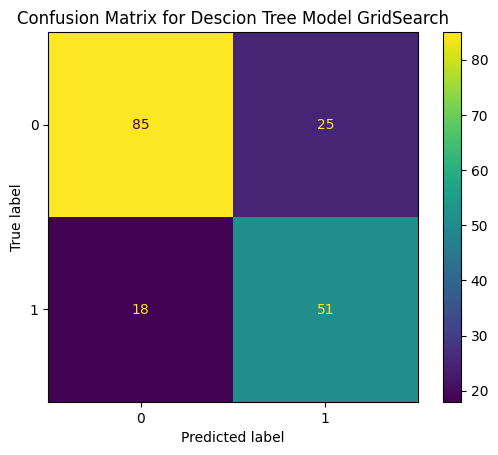

In [127]:
cm = confusion_matrix(y_test, y_dt_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix for Descion Tree Model GridSearch')
plt.show()

## 6. Model Evaluation
* Assess performance (Accuracy , Confusion Matrix and F1-score)